Random Forest using Kaggle Animal Shelter Dataset
https://www.kaggle.com/c/shelter-animal-outcomes

# Classifying the animal shelter dataset using a random forest classifier

In [42]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv as csv
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, log_loss, average_precision_score

from textblob import TextBlob

import logging

%matplotlib inline

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [3]:
# Set up my data directories from different machines

mac_data_dir = '/Users/christopherallison/Documents/Coding/Data'
linux_data_dir = '/home/chris/data'
win_data_dir = u'C:\\Users\\Owner\\Documents\\Data'

In [4]:
# Set data directory for example

data_dir = mac_data_dir

In [5]:
# Load our prepared dataset and reference data

X = pd.read_csv(os.path.join(data_dir, "prepared_animals_df.csv"),index_col=0)


In [6]:
# Check our data

X.columns

Index(['OutcomeType', 'AnimalType', 'AgeuponOutcome', 'Color', 'Intact',
       'Gender', 'NameLength', 'BreedKMeans'],
      dtype='object')

In [7]:
# Double check our data

X.head()

,OutcomeType,AnimalType,AgeuponOutcome,Color,Intact,Gender,NameLength,BreedKMeans
0,Return_to_owner,1,1,0,0,1,7,3
1,Euthanasia,0,1,1,0,0,5,0
2,Adoption,1,2,2,0,1,6,1
3,Transfer,0,0,2,1,1,3,0
4,Transfer,1,2,3,0,1,3,3


In [8]:
X.dtypes

OutcomeType       object
AnimalType         int64
AgeuponOutcome     int64
Color              int64
Intact             int64
Gender             int64
NameLength         int64
BreedKMeans        int64
dtype: object

## Label Transformation
One of the key things we need to do is transform our outcomes into matrices required for result probabilities.  Let's do this.

In [9]:
outcomes = X.OutcomeType.unique()

In [10]:
from sklearn import preprocessing

# This code takes our text labels and creates an encoder that we use
# To transform them into an array

encoder = preprocessing.LabelEncoder()
encoder.fit(outcomes)

encoded_y = encoder.transform(outcomes)
encoded_y

array([3, 2, 0, 4, 1])

In [11]:
#We can also inverse_transform them back.
list(encoder.inverse_transform([0, 1, 2, 3, 4]))

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

In [12]:
#We still need to transform the array into a matrix - this is called one hot encoding. It allows us to track the 
# probability of each possible outcome separately.

# convert integers into dummy variables (one hot encoding)

from keras.utils import np_utils

dummy_y = np_utils.to_categorical(encoded_y)
dummy_y

Using Theano backend.


array([[ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.]])

In [13]:
#We'll transform the labels into their array value, though.
X.OutcomeType = encoder.transform(X.OutcomeType)

In [14]:
# Check our work

X.head()

,OutcomeType,AnimalType,AgeuponOutcome,Color,Intact,Gender,NameLength,BreedKMeans
0,3,1,1,0,0,1,7,3
1,2,0,1,1,0,0,5,0
2,0,1,2,2,0,1,6,1
3,4,0,0,2,1,1,3,0
4,4,1,2,3,0,1,3,3


Here we're going to check our animaltype by the BreedKMeans that we set at the end of the previous notebook.

In [15]:
c = {0:'c',1:'y',2:'r', 3:'b', 4:'g'}
cmap = X.OutcomeType.map ( c )

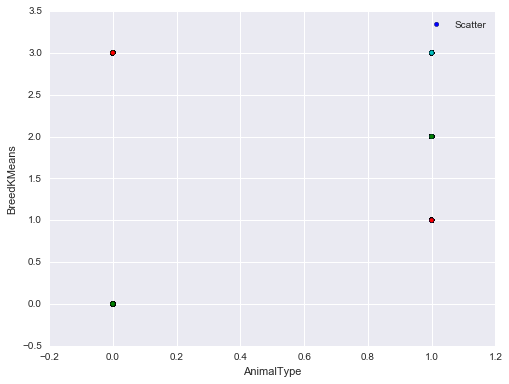

In [18]:
X.plot.scatter(x='AnimalType', y='BreedKMeans', c=cmap, label='Scatter', legend=True, figsize=(8,6))

Now we're ready to set our labels / targets.  We're going to set two types as they allow different metrics visualizations.

* train_target = matrix outcomes
* simple_target = integer target

In [19]:
train_target = np_utils.to_categorical(X['OutcomeType'].values)
train_target

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [20]:
simple_target = X.OutcomeType.values
simple_target

array([3, 2, 0, ..., 0, 4, 4])

Now we pull our training features from the dataframe.  By excluding X.values[0], we are removing the OutcomeType.

In [21]:
train_features = X.values[:,1:]
train_features[:5]

array([[1, 1, 0, 0, 1, 7, 3],
       [0, 1, 1, 0, 0, 5, 0],
       [1, 2, 2, 0, 1, 6, 1],
       [0, 0, 2, 1, 1, 3, 0],
       [1, 2, 3, 0, 1, 3, 3]])

### Test, train split

This section takes our training features and training targets and splits them into training and test batches. The classifier trains itself based on the data in the train set, and then measures it's accuracy against the remainder in the test set.  You can configure the split ratio within the function.

In [22]:
# Set up our train_test_split

X_train, x_test, y_train, y_test = train_test_split(train_features,
                                          train_target,
                                          test_size=0.4,
                                          random_state=42)

In [23]:

simple_X_train, simple_x_test, simple_y_train, simple_y_test = train_test_split(train_features,
                                          simple_target,
                                          test_size=0.4,
                                          random_state=42)

In [24]:
X.drop('OutcomeType', axis=1, inplace=True)

In [25]:
# New we finally get to the classifier!

clf = RandomForestClassifier(n_estimators=100)
simple_clf = RandomForestClassifier(n_estimators=100)

In [26]:
# Categorical classifier
clf = clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
"Mean accuracy of Random Forest: {0}".format(score)

'Mean accuracy of Random Forest: 0.6378998565816549'

In [27]:
# Simple classifier
S_clf = simple_clf.fit(simple_X_train, simple_y_train)
score = simple_clf.score(simple_X_train, simple_y_train)
"Mean accuracy of simple Random Forest: {0}".format(score)

'Mean accuracy of simple Random Forest: 0.712352684417285'

In [28]:
clf.predict(x_test[0].reshape(1, -1))

array([[ 0.,  0.,  0.,  1.,  0.]])

In [29]:
S_clf.predict(simple_x_test[0].reshape(1, -1))

array([3])

In [30]:
outcomes = encoder.inverse_transform([0, 1, 2, 3, 4])
outcomes

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [31]:
def reverse_dict_search(d, target):
    for k, v in d.items():
        if v == target:
            return k

In [32]:
# Evaluate the model
print (X_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(16037, 7) (16037, 5)
(10692, 7) (10692, 5)


In [33]:
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(x_test)

print ("Accuracy = %.2f" % (accuracy_score(y_test, y_predict)))

Accuracy = 0.52


In [34]:
outcomes

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [35]:
# Create classification report for test data

print(classification_report(y_test, 
                            y_predict, 
                            target_names=outcomes))

                 precision    recall  f1-score   support

       Adoption       0.66      0.65      0.66      4321
           Died       0.00      0.00      0.00        68
     Euthanasia       0.28      0.10      0.15       608
Return_to_owner       0.40      0.23      0.29      1917
       Transfer       0.68      0.59      0.63      3778

    avg / total       0.60      0.52      0.55     10692



In [36]:
# Metrics for the simple labels classifier

S_y_predict = S_clf.predict(simple_x_test)

In [37]:
S_y_predict

array([3, 0, 4, ..., 0, 0, 0])

In [38]:
print ("Accuracy = %.2f" % (accuracy_score(simple_y_test, S_y_predict)))

model_score = S_clf.score(simple_x_test, simple_y_test)
print ("Model Score %.2f \n" % (model_score))

confusion_matrix = metrics.confusion_matrix(simple_y_test, S_y_predict)
print ("Confusion Matrix \n", confusion_matrix)

print ("          Predicted")
print ("         |  0  |  1  |")
print ("         |-----|-----|")
print ("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                   confusion_matrix[0, 1]))
print ("Actual   |-----|-----|")
print ("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                   confusion_matrix[1, 1]))
print ("         |-----|-----|")

Accuracy = 0.59
Model Score 0.59 

Confusion Matrix 
 [[3225    4   28  504  560]
 [   7    1    2    6   52]
 [  89    1   78  121  319]
 [ 860    2   62  683  310]
 [ 963   15  122  370 2308]]
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 3225 |   4 |
Actual   |-----|-----|
       1 |   7 |   1 |
         |-----|-----|


In [39]:
print(average_precision_score(y_test, y_predict))

0.407367871446


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


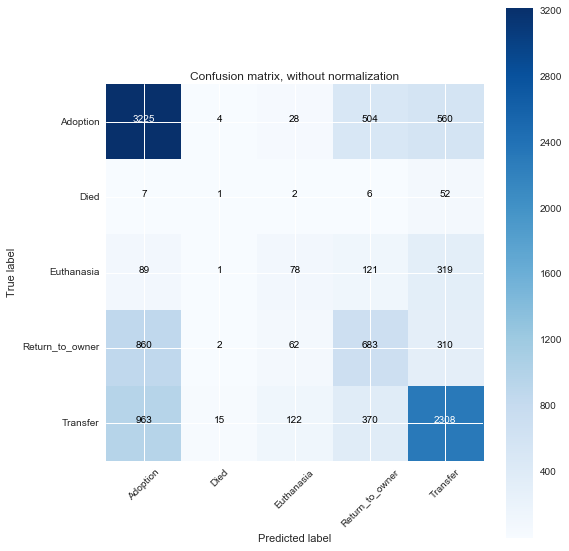

In [51]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix, classes=outcomes,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


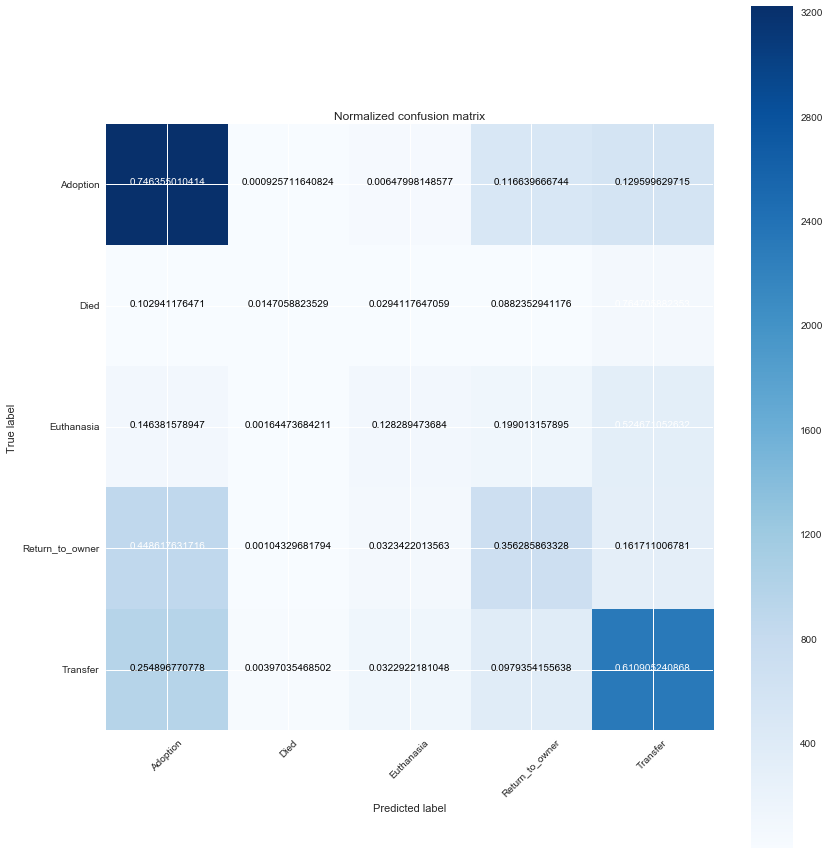

In [53]:
# Plot normalized confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(confusion_matrix, classes=outcomes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp

In [55]:
print(roc_auc_score(y_test, y_predict))

0.610230154329


In [56]:
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

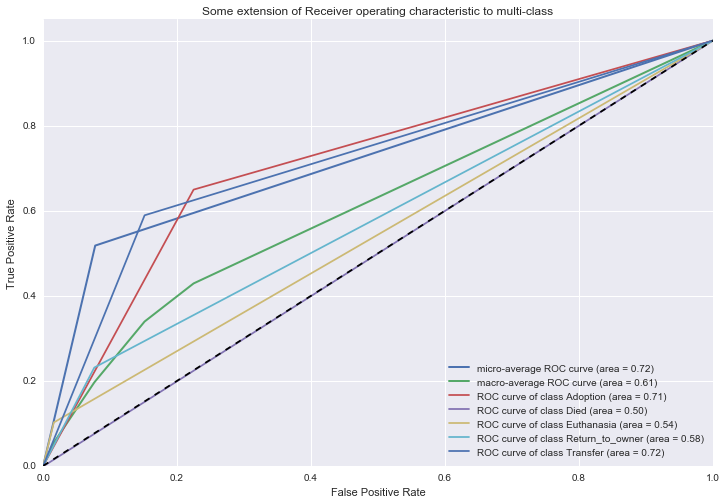

In [58]:
##############################################################################
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(outcomes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [59]:
# Plot the importance of the different features

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]
len(importances)

7

In [60]:
X.shape

(26729, 7)

1. feature Color (0.243961)
2. feature NameLength (0.237226)
3. feature Intact (0.223103)
4. feature AgeuponOutcome (0.155390)
5. feature BreedKMeans (0.060097)
6. feature AnimalType (0.048815)
7. feature Gender (0.031408)


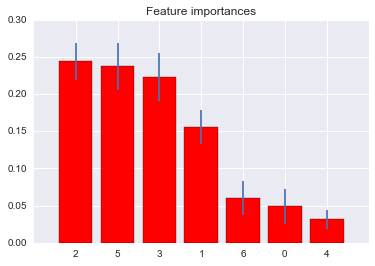

In [65]:
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### If we were happy with our model, we'd go and measure against our test data - but we want to wait until we have a solid model before we do that.

### So, we do something  else.